## Practice Description — Overview (student point of view)

In this practical activity I compared three supervised regression approaches on the Medical Cost Personal dataset. My aim was to understand how a simple linear model behaves compared to neural networks, and to learn what differences appear when using a library vs implementing back-propagation myself.

Below I organize the work following the practice description: objectives, the three models I used, the experimental protocol I followed, how I evaluated results, and final deliverables and reflections.

## Objectives (what I tried to achieve)

- Build and evaluate a baseline Multiple Linear Regression model (MLR-F) using scikit-learn.
- Implement a small feed-forward Neural Network with back-propagation from scratch (BP) and train it on the same data.
- Reproduce the same neural architecture using a modern library (BP-F — PyTorch or TensorFlow) and compare results with my implementation.
- Measure predictive performance (R², MSE, RMSE, MAE), visualize predictions, and discuss pros and cons of each approach.

# Medical Cost Personal Dataset

This dataset contains information about individual medical costs billed by health insurance. It includes demographic features such as age, sex, BMI, number of children, smoking status, and region, along with the corresponding insurance charges. The dataset is commonly used for regression tasks to predict medical costs based on personal attributes.

**Features:**
- `age`: Age of the primary beneficiary
- `sex`: Insurance contractor gender (female, male)
- `bmi`: Body mass index
- `children`: Number of children covered by health insurance
- `smoker`: Smoking status (yes, no)
- `region`: Residential area in the US (northeast, southeast, southwest, northwest)
- `charges`: Individual medical costs billed by health insurance

This notebook will explore and analyze the Medical Cost Personal Dataset.

## Models implemented

1. **MLR-F (scikit-learn)** — I used `LinearRegression` as a quick, interpretable baseline. I inspected coefficients to see feature importance under a linear assumption.

2. **BP (from-scratch neural network)** — I coded a small feed-forward network with a single hidden layer. Key points of my implementation:
   - Forward pass: matrix multiplications and activation functions (ReLU or sigmoid).
   - Loss: Mean Squared Error (MSE).
   - Back-propagation: derived gradients for weights and biases and applied gradient descent updates.
   - I experimented with learning rate, number of hidden neurons, and number of epochs.

3. **BP-F (library neural network)** — I re-created the same architecture with a library (PyTorch/TensorFlow). This allowed me to use automatic differentiation, built-in optimizers (Adam/SGD), and mini-batch training.

## Experimental protocol

- Dataset split: I used an 85/15 train/test split to match the rest of the notebook examples.
- Preprocessing: numerical features were scaled (MinMax or StandardScaler) and categorical features were encoded using one-hot encoding when needed.
- Training details: For BP-from-scratch I trained with full-batch gradient descent and tuned learning rate and hidden layer size. For BP-F I trained using mini-batches, a standard optimizer (Adam) and early stopping when validation loss stopped improving.
- Reproducibility: I set a random seed for data splitting and weight initialization where applicable.

## Evaluation and metrics

- Metrics reported: R², MSE, RMSE, MAE on training and test sets.
- Visual checks: predicted vs true scatter plots, residual histograms, and training loss curves for the neural networks.
- Comparison: I compared both numeric metrics and visual diagnostics to decide when a model was overfitting, underfitting, or making systematic errors.

## Deliverables

- Code for the scikit-learn MLR experiment (data prep, fit, evaluate).
- My implementation of a neural network with back-propagation (well-commented).
- Library-based neural network code (PyTorch or TensorFlow), training script, and saved model weights.
- A short report section (this notebook) with metrics, plots and a final comparison discussion.

## Reflection (what I learned)

Implementing these models showed me how much convenience and stability libraries provide (automatic differentiation, optimizers, data pipelines), but also how important it is to understand the mechanics under the hood. The linear baseline was quick and informative, while the neural networks required more tuning but could capture nonlinear patterns when present.


# Importació de lliberies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


c:\Users\xaviv\URV\.MESIIA\NEC\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Obtenció del dataset

In [3]:
# Set the path to the file you'd like to load
file_path = "insurance.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "mirichoi0218/insurance",
  file_path,
)
# Afegir una columna 'id' que comença en 1
df.insert(0, "id", range(0, len(df)))
df.to_csv("insurance.csv", index=False)
print("First 5 records:\n", df.head())

C:\Users\xaviv\AppData\Local\Temp\ipykernel_20968\268662106.py:5: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:
    id  age     sex     bmi  children smoker     region      charges
0   0   19  female  27.900         0    yes  southwest  16884.92400
1   1   18    male  33.770         1     no  southeast   1725.55230
2   2   28    male  33.000         3     no  southeast   4449.46200
3   3   33    male  22.705         0     no  northwest  21984.47061
4   4   32    male  28.880         0     no  northwest   3866.85520


# Preprocessament

## Pas 1:
Identificar valors no físics

In [4]:
def remove_non_physic_rows(df):
    non_physic_rows = df[
        (df['age'] <= 0) |
        (df['bmi'] <= 0) |
        (df['children'] < 0) |
        (df['charges'] < 0)
    ]

    df = df.drop(non_physic_rows.index) # Eliminar aquelles files que contenen valors no físics
    return df

ini_size = df.shape[0]
df = remove_non_physic_rows(df)
print(f"Del dataset s'han eliminat {ini_size - df.shape[0]} files no físiques. Dades restants: {df.shape[0]}")

Del dataset s'han eliminat 0 files no físiques. Dades restants: 1338


Normalització de les dades:


In [5]:


# 2️⃣ Columnes numèriques a normalitzar
cols_num = ["age", "bmi", "children", "charges"]

# 3️⃣ Crear scaler i aplicar-lo
scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df[cols_num]), columns=[col + "_norm" for col in cols_num])

# 4️⃣ Afegir les columnes normalitzades al costat de les originals
df_final = pd.concat([df, df_norm], axis=1)

# 5️⃣ Mostrar resultat
print(df_final.head(5))


   id  age     sex     bmi  children smoker     region      charges  age_norm  \
0   0   19  female  27.900         0    yes  southwest  16884.92400  0.021739   
1   1   18    male  33.770         1     no  southeast   1725.55230  0.000000   
2   2   28    male  33.000         3     no  southeast   4449.46200  0.217391   
3   3   33    male  22.705         0     no  northwest  21984.47061  0.326087   
4   4   32    male  28.880         0     no  northwest   3866.85520  0.304348   

   bmi_norm  children_norm  charges_norm  
0  0.321227            0.0      0.251611  
1  0.479150            0.2      0.009636  
2  0.458434            0.6      0.053115  
3  0.181464            0.0      0.333010  
4  0.347592            0.0      0.043816  


## Pas 2:
Detecció d'outliers

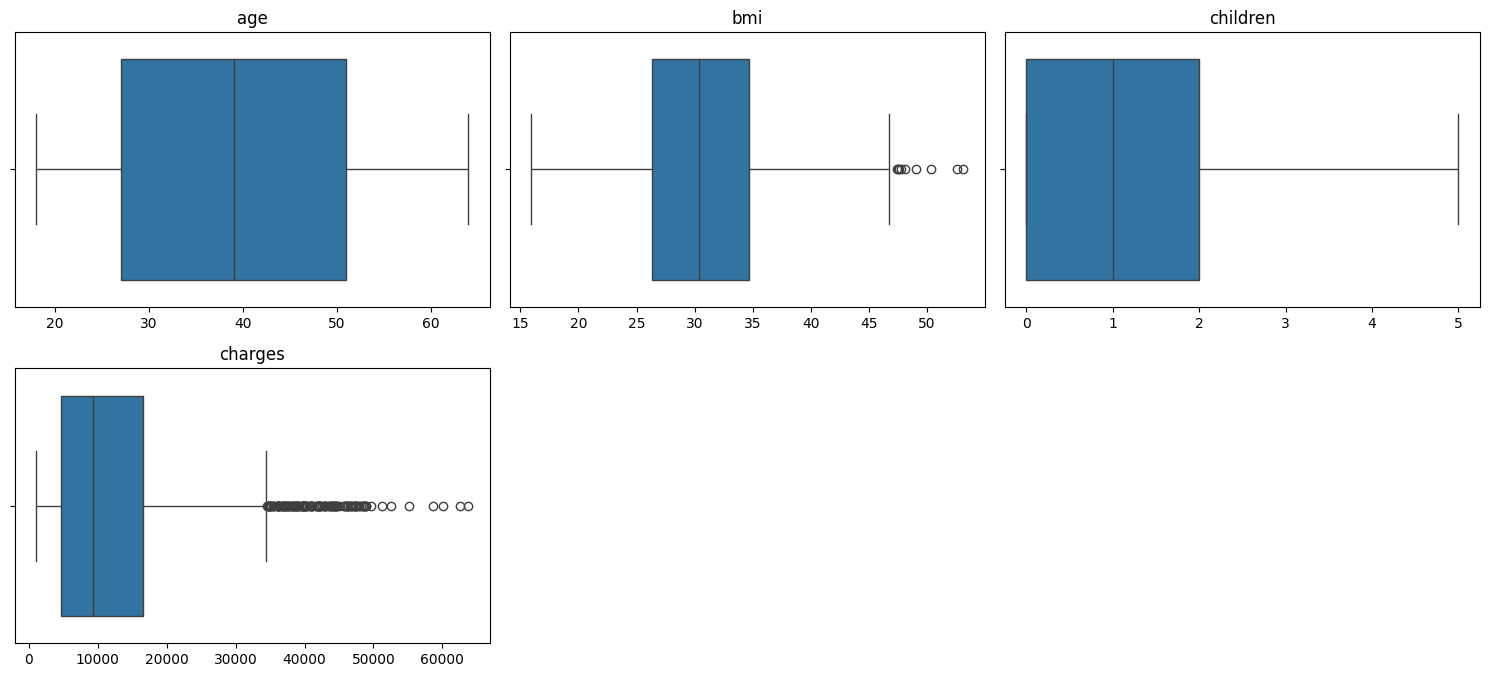

In [6]:
# Boxplots per detectar outliers
def display_distribution_bp(df):
    numeric_cols = ['age', 'bmi', 'children', 'charges']

    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numeric_cols):
        plt.subplot(3, 3, i+1)
        sns.boxplot(x=df[col])
        plt.title(col)
        plt.xlabel('')
    plt.tight_layout()
    plt.show()

display_distribution_bp(df)


Creem dataset amb outliers d'aquest pas

In [7]:
outliers = df[
    (df['bmi'] > 46.7)
]
print(df.shape)
print(outliers.shape)

(1338, 8)
(10, 8)


Ús de scatter plots per observar millor els outliers

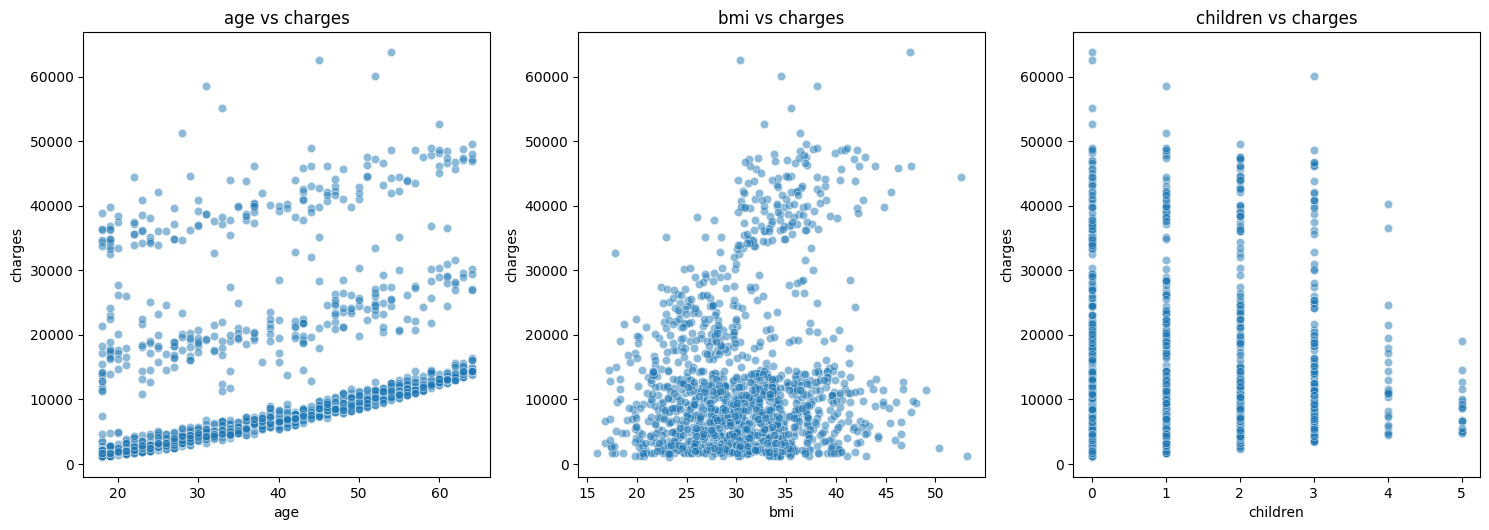

In [8]:
    # Scatter plots atribut/charges
def display_dist_vs_price_sp(df):
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(['age', 'bmi', 'children']):
        plt.subplot(2, 3, i+1)
        sns.scatterplot(data=df, x=col, y='charges', alpha=0.5)
        plt.title(f'{col} vs charges')
    plt.tight_layout()
    plt.show()

display_dist_vs_price_sp(df)


In [9]:
outliers2 = df[
    (df['charges'] > 50000)
]
print(df.shape)
print(outliers2.shape)

(1338, 8)
(7, 8)


Què fem amb els outliers?

Com tenim suficients dades, els eliminem:

In [10]:
outliers_final = pd.concat([outliers, outliers2], ignore_index=False)
outliers_final = outliers_final[~outliers_final['id'].duplicated()] # Eliminem files duplicacdes

display(outliers_final.head(5))


,id,age,sex,bmi,children,smoker,region,charges
116,116,58,male,49.06,0,no,southeast,11381.32540
286,286,46,female,48.07,2,no,northeast,9432.92530
401,401,47,male,47.52,1,no,southeast,8083.91980
438,438,52,female,46.75,5,no,southeast,12592.53450
543,543,54,female,47.41,0,yes,southeast,63770.42801


In [11]:
# Eliminació dels outliers detectats (tenim moltes dades)
df_cleaned = df_final[~df_final['id'].isin(outliers_final['id'])]
print(f"S'han eliminat {outliers_final.shape[0]} outliers del conjunt de dades. Dades restants: {df_cleaned.shape[0]}")
display(df_cleaned.head(5))

S'han eliminat 16 outliers del conjunt de dades. Dades restants: 1322


,id,age,sex,bmi,children,smoker,region,charges,age_norm,bmi_norm,children_norm,charges_norm
0,0,19,female,27.900,0,yes,southwest,16884.92400,0.021739,0.321227,0.0,0.251611
1,1,18,male,33.770,1,no,southeast,1725.55230,0.000000,0.479150,0.2,0.009636
2,2,28,male,33.000,3,no,southeast,4449.46200,0.217391,0.458434,0.6,0.053115
3,3,33,male,22.705,0,no,northwest,21984.47061,0.326087,0.181464,0.0,0.333010
4,4,32,male,28.880,0,no,northwest,3866.85520,0.304348,0.347592,0.0,0.043816


--- Dataset ---
Distribucions utilitzant boxplots


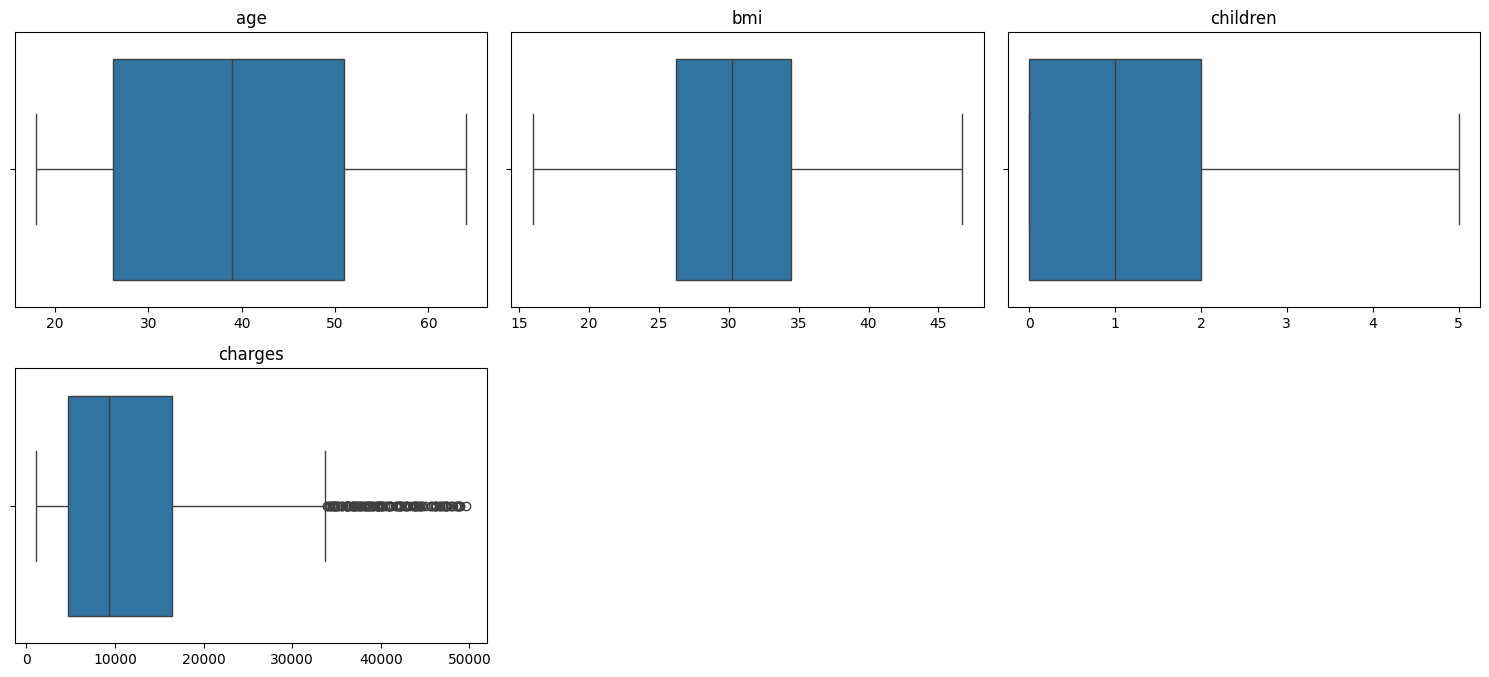

Distribucions vs Preu utilitzant scatter plots


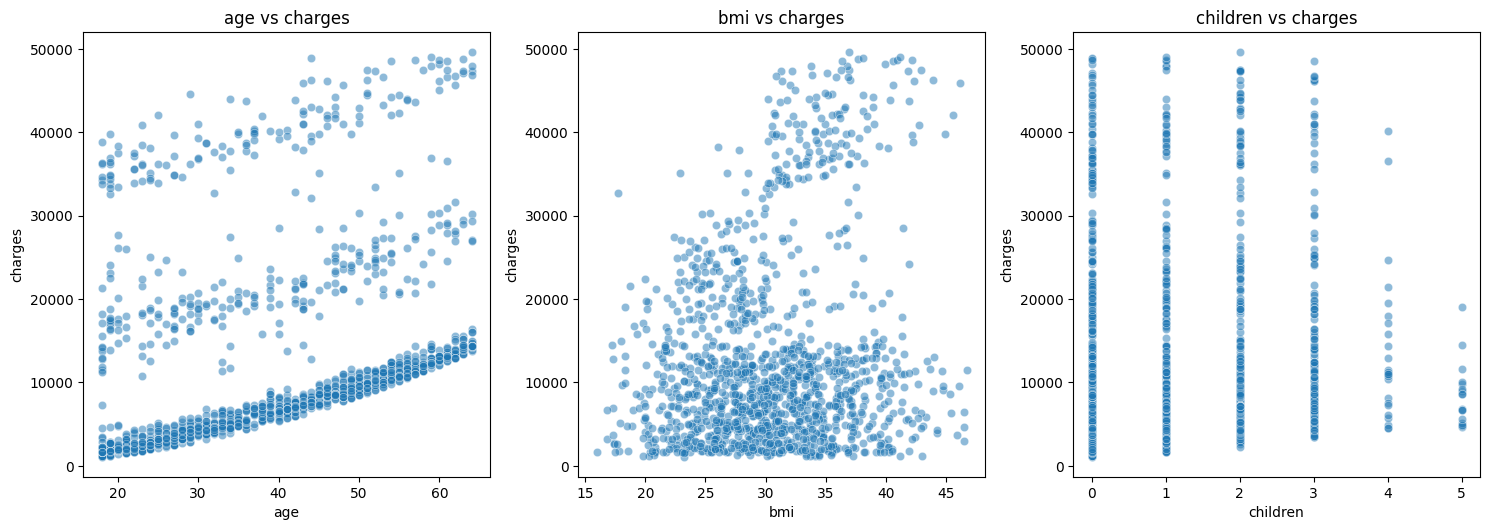

In [12]:
print("--- Dataset ---")
print("Distribucions utilitzant boxplots")
display_distribution_bp(df_cleaned)
print("Distribucions vs Preu utilitzant scatter plots")
display_dist_vs_price_sp(df_cleaned)

## Pas 3: Categòrics --> Numèrics

In [13]:
def categorical_to_numerical(df):
    # Assignem valors numèrics als atributs categòrics segons el seu ordre
    sex_mapping = {'male': 0, 'female': 1}
    smoker_mapping = {'no': 0, 'yes': 1}
    region_mapping = {'northeast': 1, 'northwest': 2, 'southeast': 3, 'southwest': 4}

    df.loc[:,'sex'] = df['sex'].map(sex_mapping)
    df.loc[:,'smoker'] = df['smoker'].map(smoker_mapping)
    df.loc[:,'region'] = df['region'].map(region_mapping)

    return df
display(df_cleaned.head())
df_cleaned = categorical_to_numerical(df_cleaned)
display(df_cleaned.head())

,id,age,sex,bmi,children,smoker,region,charges,age_norm,bmi_norm,children_norm,charges_norm
0,0,19,female,27.900,0,yes,southwest,16884.92400,0.021739,0.321227,0.0,0.251611
1,1,18,male,33.770,1,no,southeast,1725.55230,0.000000,0.479150,0.2,0.009636
2,2,28,male,33.000,3,no,southeast,4449.46200,0.217391,0.458434,0.6,0.053115
3,3,33,male,22.705,0,no,northwest,21984.47061,0.326087,0.181464,0.0,0.333010
4,4,32,male,28.880,0,no,northwest,3866.85520,0.304348,0.347592,0.0,0.043816


,id,age,sex,bmi,children,smoker,region,charges,age_norm,bmi_norm,children_norm,charges_norm
0,0,19,1,27.900,0,1,4,16884.92400,0.021739,0.321227,0.0,0.251611
1,1,18,0,33.770,1,0,3,1725.55230,0.000000,0.479150,0.2,0.009636
2,2,28,0,33.000,3,0,3,4449.46200,0.217391,0.458434,0.6,0.053115
3,3,33,0,22.705,0,0,2,21984.47061,0.326087,0.181464,0.0,0.333010
4,4,32,0,28.880,0,0,2,3866.85520,0.304348,0.347592,0.0,0.043816


In [14]:

# Split the dataset into 80% training and 20% testing
dades_train, dades_test = train_test_split(df_cleaned, test_size=0.2, random_state=42, shuffle=True)
dades_train.to_csv("dades_train.csv", index=False)
dades_test.to_csv("dades_test.csv", index=False)

print("Train Test split saved as 'dades_train.csv' and 'dades_test.csv'")

Train Test split saved as 'dades_train.csv' and 'dades_test.csv'
